# **ApisTox – Preliminary Processing**

This section loads the dataset and provides a brief overview of the data
used for honey bee toxicity classification.

In [23]:
import pandas as pd

# Load dataset (not included in repository)
DATA_PATH = "data/dataset_final.csv"
bees = pd.read_csv(DATA_PATH)

bees.head()


,name,CID,CAS,SMILES,source,year,toxicity_type,herbicide,fungicide,insecticide,other_agrochemical,label,ppdb_level
0,Ethanedioic acid,971,144-62-7,O=C(O)C(=O)O,ECOTOX,1832,Contact,0,0,0,0,0,0
1,Para-cymene,7463,99-87-6,Cc1ccc(C(C)C)cc1,BPDB,1833,Other,0,0,0,1,0,1
2,Kieselguhr,24261,61790-53-2,O=[Si]=O,ECOTOX,1833,Contact,0,0,0,0,0,0
3,Benzoic acid,243,65-85-0,O=C(O)c1ccccc1,ECOTOX,1833,Contact,1,1,1,0,0,1
4,Tetradifon (Ref: ENT 23737),8305,116-29-0,O=S(=O)(c1ccc(Cl)cc1)c1cc(Cl)c(Cl)cc1Cl,PPDB,1836,Oral,0,0,0,1,1,1


In [24]:
bees.shape, bees["label"].value_counts(normalize=True)

((1035, 13),
 label
 0    0.71401
 1    0.28599
 Name: proportion, dtype: float64)

# **Exploratory Data Analysis (EDA)**

This section provides a brief overview of the dataset, focusing on class balance
and basic structural properties before feature engineering.


In [25]:
# Basic structure of the dataset
print("Dataset shape:", bees.shape)

# Preview a few rows
bees.head(3)

# Distribution of the target variable
label_counts = bees["label"].value_counts().sort_index()
label_ratio = (label_counts / label_counts.sum()).round(3)

print("\nLabel counts:")
print(label_counts)

print("\nLabel ratio:")
print(label_ratio)


Dataset shape: (1035, 13)

Label counts:
label
0    739
1    296
Name: count, dtype: int64

Label ratio:
label
0    0.714
1    0.286
Name: count, dtype: float64


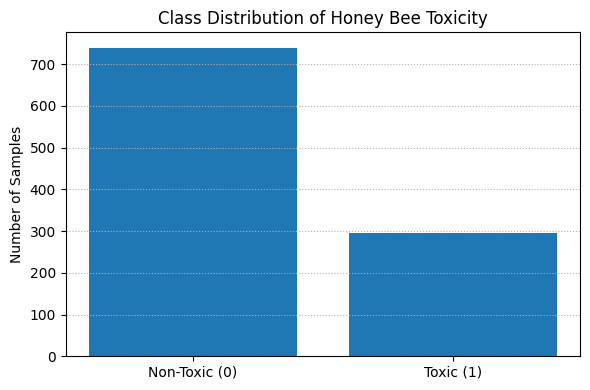

In [26]:
import os
import matplotlib.pyplot as plt

# Create directory for saving figures
os.makedirs("images", exist_ok=True)

labels = ["Non-Toxic (0)", "Toxic (1)"]
counts = bees["label"].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(labels, counts.values)
plt.title("Class Distribution of Honey Bee Toxicity")
plt.ylabel("Number of Samples")
plt.grid(axis="y", linestyle=":")
plt.tight_layout()

plt.savefig("images/class_distribution.png", dpi=200)
plt.show()


In [27]:
# Check missing values
missing_values = bees.isna().sum()
missing_values[missing_values > 0].sort_values(ascending=False)

# Check duplicated rows
duplicate_rows = bees.duplicated().sum()
print("Number of duplicated rows:", duplicate_rows)


Number of duplicated rows: 0


Based on this initial exploration, the dataset shows class imbalance,
which motivates the use of resampling techniques later.
Next, molecular descriptors are generated from SMILES strings using RDKit.


# **Feature Engineering (RDKit Descriptors)**

To enrich the tabular features, molecular descriptors are generated from SMILES strings.
These descriptors summarize basic physicochemical properties that may correlate with toxicity.


In [28]:
!pip install rdkit

In [29]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

def compute_rdkit_descriptors(smiles: str) -> pd.Series:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return pd.Series([np.nan] * 15)

    return pd.Series([
        Descriptors.MolWt(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.TPSA(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.HeavyAtomCount(mol),
        Descriptors.FractionCSP3(mol),
        Descriptors.RingCount(mol),
        Descriptors.NumAromaticRings(mol),
        Descriptors.NumAliphaticRings(mol),
        Descriptors.NumSaturatedRings(mol),
        Descriptors.NumHeteroatoms(mol),
        Descriptors.NumValenceElectrons(mol),
        Descriptors.NumRadicalElectrons(mol),
    ])


In [30]:
rdkit_cols = [
    "MolWt", "NumRotatableBonds", "TPSA", "MolLogP", "NumHDonors",
    "NumHAcceptors", "HeavyAtomCount", "FractionCSP3", "RingCount",
    "NumAromaticRings", "NumAliphaticRings", "NumSaturatedRings",
    "NumHeteroatoms", "NumValenceElectrons", "NumRadicalElectrons"
]

bees[rdkit_cols] = bees["SMILES"].apply(compute_rdkit_descriptors)
bees[rdkit_cols].head(3)


,MolWt,NumRotatableBonds,TPSA,MolLogP,NumHDonors,NumHAcceptors,HeavyAtomCount,FractionCSP3,RingCount,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeteroatoms,NumValenceElectrons,NumRadicalElectrons
0,90.034,0.0,74.60,-0.84440,2.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,4.0,34.0,0.0
1,134.222,1.0,0.00,3.11842,0.0,0.0,10.0,0.4,1.0,1.0,0.0,0.0,0.0,54.0,0.0
2,60.084,0.0,34.14,-0.61840,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,16.0,0.0


In [31]:
missing_rdkit = bees[rdkit_cols].isna().sum().sort_values(ascending=False)
missing_rdkit[missing_rdkit > 0]


,0


With RDKit descriptors added, the next step is to prepare the final feature matrix.
The data will be split into train/test sets first, and SMOTE will be applied only to the training set.


# **Modeling**

The goal is to build a classifier with high recall for the toxic class.
To avoid data leakage, resampling is applied only to the training set.


In [32]:
# Separate features and target
X = bees.drop(
    ["ppdb_level", "name", "CID", "CAS", "SMILES", "label"],
    axis=1
)
y = bees["label"]

# One-hot encode categorical variables
X = pd.get_dummies(
    X,
    columns=["source", "toxicity_type"],
    drop_first=True
)

X.shape, y.shape


((1035, 24), (1035,))

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((828, 24), (207, 24))

In [34]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

y_train.value_counts(), y_train_res.value_counts()


(label
 0    591
 1    237
 Name: count, dtype: int64,
 label
 0    591
 1    591
 Name: count, dtype: int64)

In [35]:
from sklearn.ensemble import RandomForestClassifier

final_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

final_rf.fit(X_train_res, y_train_res)


RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [36]:
from sklearn.metrics import classification_report, recall_score

y_pred = final_rf.predict(X_test)

print(classification_report(y_test, y_pred))
print("Recall (toxic=1):", recall_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.90      0.88       148
           1       0.72      0.66      0.69        59

    accuracy                           0.83       207
   macro avg       0.80      0.78      0.79       207
weighted avg       0.83      0.83      0.83       207

Recall (toxic=1): 0.6610169491525424


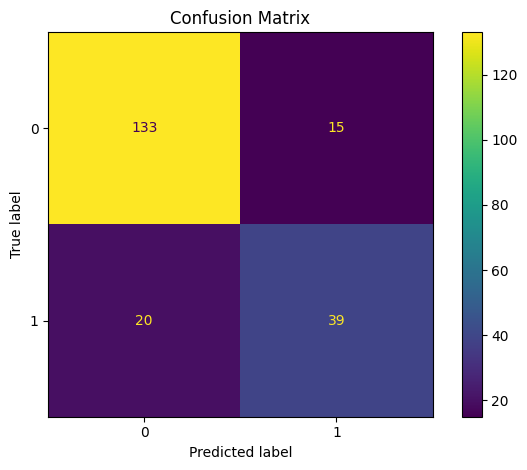

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

os.makedirs("images", exist_ok=True)

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("images/confusion_matrix.png", dpi=200)
plt.show()


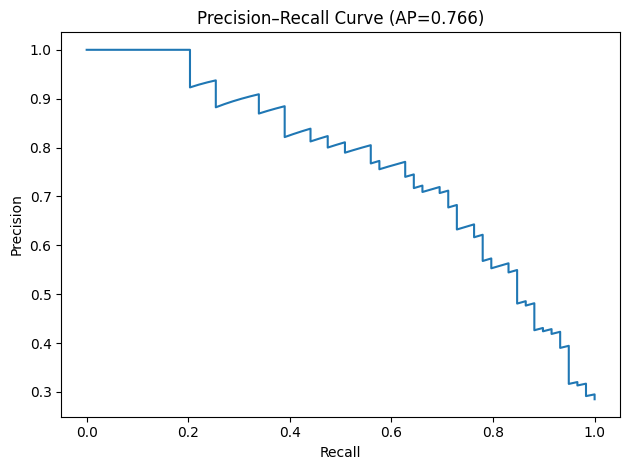

np.float64(0.7657976210720691)

In [38]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_proba = final_rf.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP={ap:.3f})")
plt.tight_layout()
plt.savefig("images/pr_curve.png", dpi=200)
plt.show()

ap


The tuned Random Forest achieves strong recall for the toxic class,
which aligns with the primary objective of minimizing false negatives.


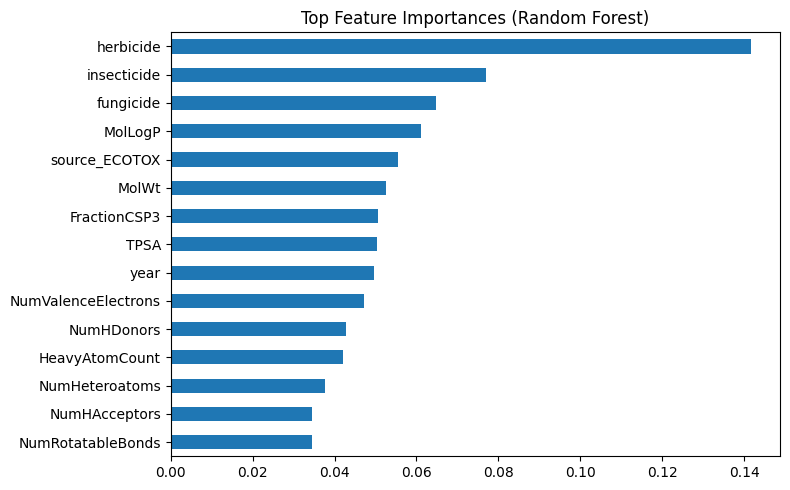

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import os

os.makedirs("images", exist_ok=True)

importances = pd.Series(
    final_rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

top_imp = importances.head(15)

plt.figure(figsize=(8, 5))
top_imp.sort_values().plot(kind="barh")
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.savefig("images/feature_importance.png", dpi=200)
plt.show()


# **Model Interpretation**

Feature importance analysis shows that agrochemical type indicators
and physicochemical descriptors such as MolLogP and MolWt
are strong contributors to toxicity prediction.

These results align with domain expectations and improve model transparency.